# Gaussian kernel Approximation
### In this code we approximate the Gaussian kernel of two graphs by the dot product of two k-random features consinus vectors, each belongs to the corresponding graph
### Datasets used: mutag, SBM
### Graph sampling technique used in this code: Random Walk With flyback 
### Machine learning algo: SVM with kernel

In [67]:
import grakel as gk
import networkx as nx
import Graph_Sampling as gs
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from grakel.datasets import fetch_dataset
from random import random
from grakel import Graph
from grakel.kernels import ShortestPath
from sklearn.utils import shuffle 


## graph building and sampling Visualization
### this is to be done by networkx (and matplotlib package for visualization) with the purpose of testing the sampling technique via Graph_Sampling package


C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


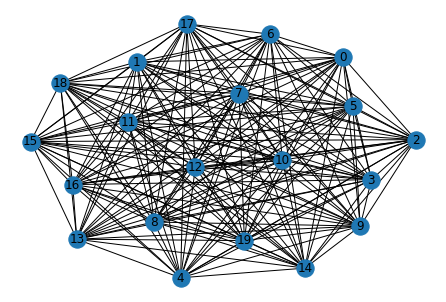

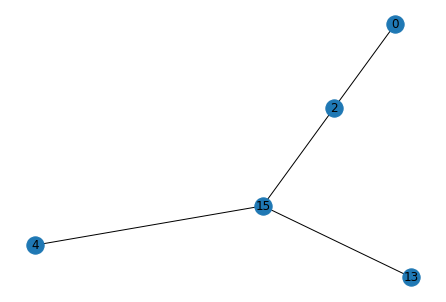

In [68]:
G=nx.complete_graph(20)
nx.draw(G,with_labels=True)
plt.show()
p=0.5
object = gs.SRW_RWF_ISRW()             
#sampled_subgraph = object.random_walk_sampling_simple(G,8)
sampled_subgraph = object.random_walk_sampling_with_fly_back(G,5,p)
nx.draw(nx.Graph(sampled_subgraph),with_labels=True)


plt.show()


## Random Features Structure

In [69]:
def random_feature_flyback_sampling(G,nodes_num, features_num, samples_num, p_flyback, feature_mat):
    '''
    output: random features vector of G computed as the average of the 
            random feature vectors of its subgraphs
            sampling method: random walk with fly back
    input: graph G
            number of features to be computed
            number of subsamples to be considered
            feature_mat: random features projection matrix
            pdf: the probability dist function of each of the frequencies included in feature_mat (each row is an freq)
    '''
    object=gs.SRW_RWF_ISRW();
    for _ in range (samples_num):
        sampled_subgraph=object.random_walk_sampling_with_fly_back(G,nodes_num,p_flyback)
        adjacency=nx.to_numpy_matrix(sampled_subgraph).flatten().T if _==0 \
                  else np.append(adjacency,nx.to_numpy_matrix(sampled_subgraph).flatten().T,axis=1)
    random_feature=np.cos(feature_mat.dot(adjacency))       # theta is the product of w with Adacency matrix
    return np.mean(random_feature,axis=1)


def random_features_projection_matrix(sigma,nodes_num, features_num):
    '''
    this function returns the random feature projection matrix that corresponds to Gaussian kernel
    output: feature_mat: random features projection matrix
            pdf: the probability dist function of each of the frequencies included in feature_mat (each row is an freq)
    input: sigma : the deviation of the normal distribution
           nodes_num: the number of nodes to be sampled from the graph ( used in feature_mat shape)
           feature_num: number of frequencies to be considered
    '''
    norm_dist=stats.norm(0,sigma)    # the distribution of frequencies ( Gaussian kernel)
    feature_mat=sigma*np.random.randn(features_num,nodes_num**2) 
    # calculating the probailiy of each of the resulting frequencies
    for i in range (nodes_num**2):pdf=norm_dist.pdf(feature_mat[:,0]) if i==0 else pdf*norm_dist.pdf(feature_mat[:,i])
    pdf=pdf/max(pdf)
    return feature_mat, pdf

nodes_num, features_num, samples_num, p_flyback, sigma=6, 5, 200, 0.5, 1

proj_matrix,pdf=random_features_projection_matrix(sigma,nodes_num, features_num)
#print(proj_matrix)
#print(pdf)

In [70]:
# mutag dataset
Gnx_train=[];
Gnx_test=[];
MUTAG = fetch_dataset("MUTAG", verbose=False,as_graphs=False)
G, y = MUTAG.data, MUTAG.target
G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1, random_state=42)
for i in range(len(G_train)):
    g_current=nx.Graph(list(G_train[i][2]));
    g_current.add_nodes_from(G_train[i][1])
    Gnx_train.append(g_current)
for i in range(len(G_test)):
    g_current=nx.Graph(list(G_test[i][2]));
    g_current.add_nodes_from(G_test[i][1])
    Gnx_test.append(g_current)


# random dataset
G = list()
y = list()
probs = [0.25, 0.5, 0.75]
for i in range(len(probs)):
    for j in range(5, 55):
            edges = list()
            for n1 in range(j):
                    for n2 in range(n1+1, j):
                            if random() <= probs[i]:
                                    edges.append((n1, n2))
                                    edges.append((n2, n1))

            G.append(nx.Graph(edges))
            y.append(i)
G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1, random_state=42)
Gnx_train,Gnx_test=G_train,G_test

In [71]:
#SBM dataset generator
Graphs_num,nodes_per_graph,block_size=100,102,34
blocks_num=int(nodes_per_graph/block_size)
sizes=[block_size]*blocks_num
fraction=0.4;
avg_deg=fraction*block_size;
G,y=[],[]
for i in range (Graphs_num):
    p_in=(fraction/3)*(1+i/(Graphs_num/2));
    p_out=(avg_deg-(block_size-1)*p_in)/(nodes_per_graph-block_size)
    p=p_out*np.ones([blocks_num]*2)+(p_in-p_out)*np.eye(blocks_num)
    G.append(nx.stochastic_block_model(sizes, p, seed=0))
    y.append(-1 if i<Graphs_num/2 else 1)
G, y = shuffle(G, y, random_state=0)
G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1, random_state=42)
Gnx_train,Gnx_test=G_train,G_test

# Calculating the kernel and training the SVM model

In [72]:

for i in range(len(Gnx_train)):
    if i==0:
        random_features_train=random_feature_flyback_sampling(Gnx_train[i],nodes_num, features_num, 
                                                              samples_num, p_flyback, proj_matrix)
    else:
        random_features_train=np.append(random_features_train,
                                        random_feature_flyback_sampling(Gnx_train[i],nodes_num, 
                                                                        features_num, samples_num,
                                                                        p_flyback, proj_matrix),axis=1)
    print(i)
for i in range(len(Gnx_test)):
    if i==0:
        random_features_test=random_feature_flyback_sampling(Gnx_test[i],nodes_num, features_num, 
                                                              samples_num, p_flyback, proj_matrix)
    else:
        random_features_test=np.append(random_features_test,
                                        random_feature_flyback_sampling(Gnx_test[i],nodes_num, 
                                                                        features_num, samples_num,
                                                                        p_flyback, proj_matrix),axis=1)
K_train =random_features_train.T.dot(np.multiply(pdf.reshape(features_num,1),random_features_train))
K_test =random_features_test.T.dot(np.multiply(pdf.reshape(features_num,1),random_features_train))
#print(K_train.shape)
#print(K_test.shape)
clf = SVC(kernel="precomputed")
clf.fit(K_train, y_train)
y_pred = clf.predict(K_test)

# Computes and prints the classification accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", str(round(acc*100, 2)) + "%")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
Accuracy: 20.0%
